In [4]:
# Warning: usually don't do this kind of inclusion : using *, you 'merge' the namespaces
#          but in this case we actually want to mimic the imports as if they were imported here
from src.setup import *

from src.host import run_plink
from src import host
from src import common

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Comutation management
DATA_THINNING = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

**14'738'460 variants, 622 people.**

## Data processing plan

### Preprocessing 

1. Data thinning (if `DATA_THINNING == True`)
1. Create SNP map (SNP id and SNP position)

### Filtering
1. Remove missing values (variants)
1. Remove missing values (individuals)
1. Filter out rare variants and variants at Hardy-Weinberg disequilibrium

## Computation and path management

### Idea

Sometimes we don't want to re-do all the computations if the resulting data is already calculated. The features provided below aim to easily manage the paths and the computations:
1. A way of easily running shell commands
1. A dedicated function to easily run plink commands on the shell
1. A way of checking if the results already exist, and loading data if this is the case
    * Unless we specifically specifiy to re-do the calculations.

###### DOCUMENTATION 

Running shell commands and managing the outputs : https://janakiev.com/til/python-shell-commands/, https://www.pythonforbeginners.com/os/subprocess-for-system-administrators

### General principle

* `run_shell_command`: manage to run shell commands with a specific package (`subprocess`) that helps to manage the outputs. Returns a 2-tuple (stdout, stderr).
* `run_plink`: manage plink version, binary files location, output location, display errors, check if results already exist.

*NOTE: possible improvement: automatically find the file extension. Also, if the command results in several output files, we should check that all of them are present. So **be careful, we assume the user doesn't  only a fraction of the output files**.*

###### Workflow
1. Call `run_plink` command with the specific command (e.g. `--freq`), the input, the output and the file extension to look for (to avoid re-doing the computations). 
1. The function checks if the result already exist (needs the output and the extension resulting from the command)
    * already exists: display a message, abort the process (returns 2-tuple of empty strings). This occurs if `force==False` (which is the default value).
1. The command is runned with plink2 by default
1. The error messages are displayed (by default, `verbose_err=True`)
1. The outputs are returned as a tuple (stdout, stderr)

###### Modify behaviour

Change the boolean value defined in the first cell of this notebook.

### Path management

In [9]:
path_raw = setup.PATH_HOST_RAW_PLINK_DATA
path_out = setup.PATH_PLINK_DATA
file_prefix = 'host_geno'

if not os.path.exists(setup.PATH_PLINK_LOG):
    os.system('mkdir '+setup.PATH_PLINK_LOG)
    print("Created the directory", setup.PATH_PLINK_LOG)

## Overview on raw data

### Files

In [7]:
path = setup.PATH_HOST_RAW_DATA
!ls -lh $path

total 6.6G
-rwxr-xr-x 1 mazeller SV-BA4-unit  245 Aug  9 16:11 dictionary_wes_vcf.txt
-rw-r--r-- 1 mazeller SV-BA4-unit 2.2G Aug 13 15:09 hbv_gilead_bcftools.bed
-rw-r--r-- 1 mazeller SV-BA4-unit 431M Aug 13 15:09 hbv_gilead_bcftools.bim
-rw-r--r-- 1 mazeller SV-BA4-unit  18K Aug 13 15:09 hbv_gilead_bcftools.fam
-rwxr-xr-x 1 mazeller SV-BA4-unit 2.2G Aug  9 16:11 hbv_gilead.bed
-rwxr-xr-x 1 mazeller SV-BA4-unit 431M Aug  9 16:11 hbv_gilead.bim
-rwxr-xr-x 1 mazeller SV-BA4-unit  18K Aug  9 16:11 hbv_gilead.fam
-rw-r--r-- 1 mazeller SV-BA4-unit 1.4G Aug 11 01:59 hbv_gilead.frq
-rw-r--r-- 1 mazeller SV-BA4-unit  930 Aug 11 01:59 hbv_gilead.log
-rw-r--r-- 1 mazeller SV-BA4-unit  13K Aug 11 01:59 hbv_gilead.nosex
-rw-r--r-- 1 mazeller SV-BA4-unit  677 Aug 11 17:56 hbv_gilead_validate.log


Those are **plink binary files**. 

### Dictionnary of the data

In [4]:
!cat $path/dictionary_wes_vcf.txt

Info about WES_VCF by Ondrej.Podlaha@gilead.com on Dec 12 2018.

1. Human reference genome: GRCh37.87
2. Variant calling was performed using GATK (version nightly-2016-08-27-g667f78b; HaplotypeCaller)
3. dbSNP v138 was used by HaplotypeCaller
 


### Data integrity


In [5]:
run_plink('--validate', file=path_raw, out=path_out+file_prefix+'_validate', 
               extension='log', log_name='validate')
!cat $setup.PATH_PLINK_LOG'validate.log'

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/host_geno_validate --validate '
Log written to 'data/plink/log/validate.log'
PLINK v2.00a2LM 64-bit Intel (31 Jul 2019)     www.cog-genomics.org/plink/2.0/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/plink/host_geno_validate.log.
Options in effect:
  --bfile data/raw/wes_plink/hbv_gilead_bcftools
  --out data/plink/host_geno_validate
  --validate

Start time: Tue Aug 13 17:31:45 2019
64232 MiB RAM detected; reserving 32116 MiB for main workspace.
Using up to 16 threads (change this with --threads).
622 samples (0 females, 0 males, 622 ambiguous; 622 founders) loaded from
data/raw/wes_plink/hbv_gilead_bcftools.fam.
14738460 variants loaded from data/raw/wes_plink/hbv_gilead_bcftools.bim.
Validating data/raw/wes_plink/hbv_gilead_bcftools.bed... done.
End time: Tue Aug 13 17:31:51 2019


## .bim file

This is an extended .map file, 
1. Chromosode code
1. Variant id (SNP)
1. Position in centimorgan
1. Baise-pair coordinate
1. ALT allele code
1. REF allele code

In [6]:
!head -10 $path_raw'.bim'

1	rs779258992	0	10146	A	AC
1	1:10400:C:T	0	10400	T	C
1	rs55998931	0	10492	T	C
1	rs58108140	0	10583	A	G
1	rs376342519	0	10616	C	CCGCCGTTGCAAAGGCGCGCCG
1	1:13012:A:G	0	13012	A	G
1	1:13054:C:T	0	13054	T	C
1	1:13250:G:T	0	13250	T	G
1	rs531730856	0	13273	C	G
1	rs538791886	0	13289	C	CCT


## Arbitrary thinning of the data

We use the plink2 `--thin <p>` option to **reduce the amount of data** (keep entries with probability p). We'll make sure that the code runs first. When everything works, we can simply set `DATA_THINNING = False`.

Management of the **data being taken into account**: we simply put `path_raw` to target the reduced data.

In [7]:
# We change the default raw data for subsequent analyses
if DATA_THINNING == True :
    file_prefix = 'host_reduced'
    run_plink("--thin 0.001 --make-bed", file=path_raw, out=path_out+file_prefix, 
              extension='bed', log_name='thinning')
    path_raw = path_out+file_prefix

## Note on plink

| Feature | Summary statistic | Inclusion criteria  |
|----------------------------|-----------|-----------|
| Missingness per individual | --missing | --mind N  |
| Missingness per marker     | --missing | --geno N  |
| Allele frequency           | --freq    | --maf N   |
| Hardy-Weinberg equilibrium | --hardy   | --hwe     |
| Mendel error rates         | --mendel  |  --me N M |

# SNP map generation

We create a Python dictionnary object and store it to easily convert the SNP references to their genome location. Those information are extracted from the `.bim` file.


In [8]:
# Create dictionnary
# Use custom manage_pickle function from common.py
def create_dict() :
    # Create DataFrame from .bim file
    df_bim = pd.read_csv(path_raw+'.bim', sep='\s+', header=None,
                         usecols=[0, 1, 3])
    df_bim.columns = ['#CHROM', 'SNP', 'COORD']
    print(df_bim.head(1))
    return dict(zip(df_bim['SNP'], df_bim['COORD']))

SNP_dic = common.manage_pickle(path=setup.PATH_SNP_MAP, fun=create_dict)

manage_pickle: the file 'data/SNP_dict' has been loaded


# Missing values

`.smiss` for sample-based missing data report:
* MISSING_CT: Number of missing hardcalls, not counting het haploids
* OBS_CT = Denominator (#males on chrY, otherwise #samples)
* F_MISS = Missing hardcall rate, not counting het haploids



In [9]:
path_missing = path_out+file_prefix+'_missing'
o,e = run_plink("--missing", file=path_raw, out=path_missing, 
                extension='vmiss', log_name='missing')

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/host_geno_missing --missing '
Log written to 'data/plink/log/missing.log'


In [10]:
df_miss_ind = pd.read_csv(path_missing+'.smiss', sep='\s+', usecols=['F_MISS'])
df_miss_var = pd.read_csv(path_missing+'.vmiss', sep='\s+', usecols=['#CHROM', 'ID', 'F_MISS'])
print("Shape of missing var table: {}\nColumns of missing var table:\n\t{}\
\nShape of missing ind table: {}\nColumns of missing ind table:\n\t{}"
     .format(df_miss_var.shape, df_miss_var.columns, 
             df_miss_ind.shape, df_miss_ind.columns))

/home/mazeller/HBV/opt/x86_E5v2_IntelIB/venv-gcc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape of missing var table: (14738460, 3)
Columns of missing var table:
	Index(['#CHROM', 'ID', 'F_MISS'], dtype='object')
Shape of missing ind table: (622, 1)
Columns of missing ind table:
	Index(['F_MISS'], dtype='object')


## Missingness of individuals per variant

For each individual, plink computed the rate of missing variants. This tells us about how to filter individuals out.

In [11]:
df_miss_ind.head(1)

,F_MISS
0,0.867208


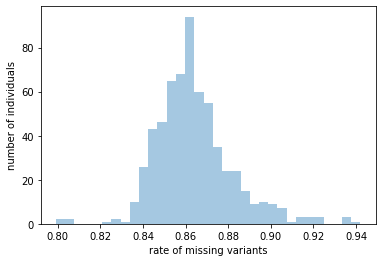

In [12]:
sns.distplot(df_miss_ind['F_MISS'], norm_hist=False, kde=False)
plt.ylabel('number of individuals'); plt.xlabel('rate of missing variants');

## Missing report - variants

For each variant, plink computed the rate of missing individuals. This tells us about how to filter variants out.

In [13]:
#df_miss_var['COORD'] = df_miss_var.ID.map(SNP_dic)
#df_miss_var.head(1)

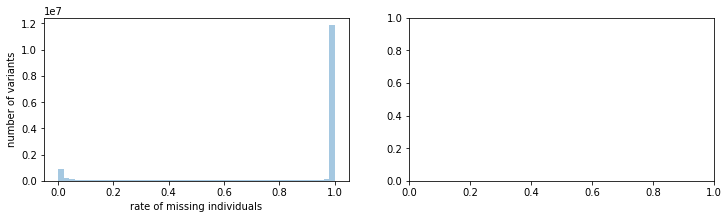

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
# Plot missing rate histogram
sns.distplot(df_miss_var.F_MISS.dropna(), kde=False, norm_hist=False, ax=ax[0])
ax[0].set_xlabel('rate of missing individuals'); ax[0].set_ylabel('number of variants');
# Plot missing rate per position
#sns.scatterplot(x=df_miss_var.COORD, y=df_miss_var.F_MISS, ax=ax[1]);
#ax[0].set_xlabel('position'); ax[0].set_ylabel('rate of missing individuals');

### Median missingness per chromosome

**WARNING: this may take a while if the data is not reduced.**

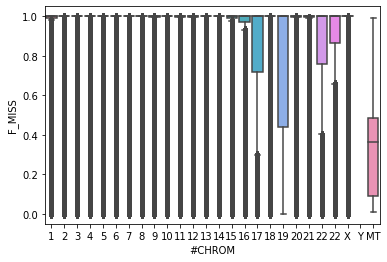

In [15]:
df_miss_chr = df_miss_var[['#CHROM', 'F_MISS']].groupby('#CHROM').median()
sns.boxplot(x='#CHROM', y='F_MISS', data=df_miss_var);

## Summary of missing reports

We indeed expect to have almost no items with very few missing variants: missingness has more to do with the sequencing method and the genome location (than randomness). There is no individual that would be specifically better sequenced than others (excluding randomness). In contrast, we expect some variants to be missing in almost all individuals or to be present in all of them.

Report `.smiss` (individuals): for each individual, we're interested in the rate of missing variants. That tells us which individuals have too much missingness. There is actually a huge number of individuals with a missing rate >80%. It can arise from that fact that:
1. We have low-quality sequencing data
1. If we use reduced data, the sub-sample we have has a lot of missingness by random
1. **Missingness is biased**, since we did not exclude the variants with high missing rates.

Remember that we want to be very careful while excluding individuals, we want to save them due to the small sample size. Just like we did in the viral sequencing data, we must first remove bad variants before removing individuals.


In [16]:
# Free memory
df_miss_var = None
df_miss_ind = None
df_miss_chr = None

# NaN values processing

We use the filtering options of plink2 (i.e. `--geno` and `--mind`) together with `--make-bed` to create a new dataset.

**NOTE: after data cleaning, we set `file_prefix = file_prefix+'_clean'`.**

In [17]:
# Managing paths and files
file_prefix = file_prefix + '_clean'
path_clean = path_out+file_prefix

In [18]:
path_clean_variants = path_clean+'_var'
run_plink('--geno ' + str(setup.THRESHOLD_MISSING_VARIANTS) + ' --make-bed', file=path_raw, 
          out=path_clean_variants, extension='bed', log_name='filter_variants');

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/host_geno_clean_var --geno 0.01 --make-bed '
Log written to 'data/plink/log/filter_variants.log'


In [19]:
# We overwrite on the intermediate clean dataset
# Thus we must call run_plink with force=True
path_clean_ind = path_clean+'_ind'
run_plink('--mind ' + str(setup.THRESHOLD_MISSING_INDIVIDUALS) + ' --make-bed', 
          file=path_clean_variants, 
          out=path_clean_ind, extension='bed', log_name='file_individuals');

Running 'plink2 --bfile data/plink/host_geno_clean_var --out data/plink/host_geno_clean_ind --mind 0.1 --make-bed '
Log written to 'data/plink/log/file_individuals.log'


## Check again missingness


Running 'plink2 --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind --missing '
Log written to 'data/plink/log/missing_again.log'


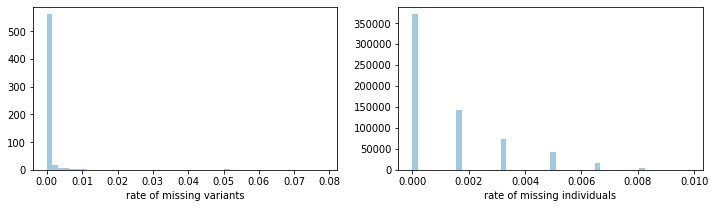

In [20]:
# Run plink
run_plink('--missing', file=path_clean_ind, out=path_clean_ind, extension='vmiss',
         log_name='missing_again')
# Put in DataFrames
# NOTE: param usecols DRASTICALLY lowers the amount of memory used
df_miss_ind = pd.read_csv(path_clean_ind+'.smiss', sep='\s+', usecols=['F_MISS'])
df_miss_var = pd.read_csv(path_clean_ind+'.vmiss', sep='\s+', usecols=['F_MISS'])
# Plotting
fig, ax = plt.subplots(1,2, figsize=(12, 3))
sns.distplot(df_miss_ind.F_MISS.dropna(), kde=False, ax=ax[0])
ax[0].set_xlabel('rate of missing variants')
sns.distplot(df_miss_var.F_MISS.dropna(), kde=False, ax=ax[1])
ax[1].set_xlabel('rate of missing individuals');
# Free memory
df_miss_var = None
df_miss_ind = None

# Minor allele frequencies

## plink1.9 report

* A1: minor allele (usually)
* A2: major allele (usually)
* MAF: frequency of A1

Running 'plink --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind --freq '
treat these as missing.



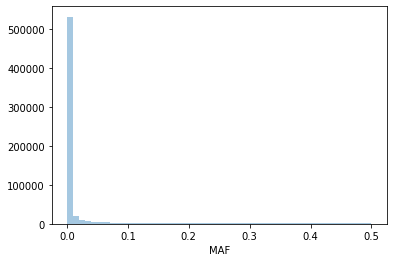

In [21]:
path_freq = path_clean_ind
run_plink('--freq', extension='frq', file=path_clean_ind, 
          out=path_clean_ind, plink2=False, log_name='freq_plink1');
df_freq = pd.read_csv(path_freq+".frq", sep="\s+")
df_freq.head(1)
sns.distplot(df_freq.MAF.dropna(), kde=False);

In [22]:
frequencies = [0.1, 0.05, 0.01, 0.005]
print("Percentage of variants to drop for different frequency thresholds:")
N = len(df_freq.MAF)
for f in frequencies :
    variants = df_freq.MAF[df_freq.MAF < f]
    print("{}\t{:.3}%".format(f, len(variants)/N*100))

Percentage of variants to drop for different frequency thresholds:
0.1	86.9%
0.05	84.5%
0.01	78.6%
0.005	74.7%


## plink2 report

Running 'plink2 --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind --freq '
Log written to 'data/plink/log/freq_plink2.log'


/home/mazeller/HBV/opt/x86_E5v2_IntelIB/venv-gcc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


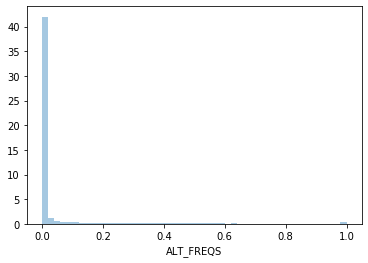

In [23]:
path_freq = path_clean_ind
run_plink('--freq', extension='afreq', file=path_clean_ind, out=path_freq, log_name='freq_plink2');
df_freq = pd.read_csv(path_freq+".afreq", sep="\s+")
df_freq.head(1)
sns.distplot(df_freq.ALT_FREQS.dropna(), kde=False, norm_hist=True);

## MAF summary



In [24]:
df_freq = None

# Hardy-Weinberg equilibrium

* A1: Tested allele
* AX: Non-A1 alleles (comma-separated)
* HOM_A1_CT: Homozygous-A1 genotype count
* HET_A1_CT: Heterozygous-A1 genotype count
* TWO_AX_CT: number of NONmissing calls with no A1 copies
* O(HET_A1): Observed heterozygous-major frequency
* E(HET_A1): Expected heterozygous-major frequency
* P: Hardy-Weinberg equilibrium exact test p-value

In [25]:
path_hardy = path_clean_ind+'_hardy'
run_plink('--hardy', file=path_clean_ind, out=path_hardy, 
          extension='hardy', log_name='hardy');

Running 'plink2 --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind_hardy --hardy '
Log written to 'data/plink/log/hardy.log'


In [26]:
df_hardy = pd.read_csv(path_hardy+'.hardy', sep="\s+")
df_hardy.head(3)

,#CHROM,ID,A1,AX,HOM_A1_CT,HET_A1_CT,TWO_AX_CT,O(HET_A1),E(HET_A1),P
0,1,1:14773:C:T,C,T,607,3,0,0.004918,0.004906,1.0
1,1,rs571121669,C,T,605,4,0,0.006568,0.006547,1.0
2,1,rs201013861,G,A,609,1,0,0.001639,0.001638,1.0


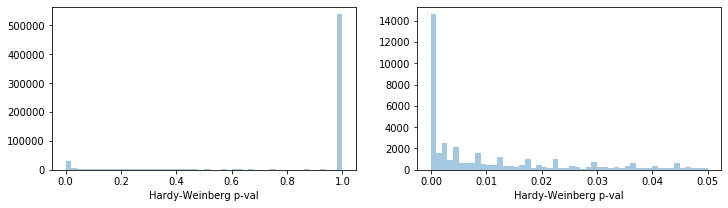

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
sns.distplot(df_hardy.P, kde=False, ax=ax[0])
ax[0].set_xlabel('Hardy-Weinberg p-val');

sns.distplot(df_hardy.P[df_hardy.P <= 0.05], kde=False, ax=ax[1])
ax[1].set_xlabel('Hardy-Weinberg p-val');

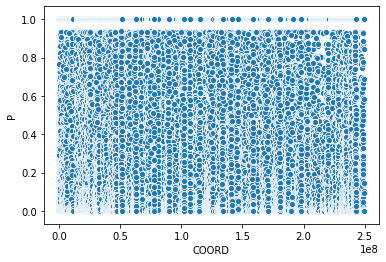

In [28]:
df_hardy['COORD'] = df_hardy.ID.map(SNP_dic)
sns.scatterplot(x=df_hardy.COORD, y=df_hardy.P);

# Mendelian error rates

[Quote](http://zzz.bwh.harvard.edu/plink/summary.shtml#mendel):
> The `*.mendel` file contains all Mendel errors (i.e. one line per error); the `*.imendel` file contains a summary of per-individual error rates; the `*.fmendel` file contains a summary of per-family error rates; the `*.lmendel` file contains a summary of per-SNP error rates. 

In [29]:
run_plink("--mendel", extension='mendel', file=path_clean_ind,
          out=path_clean_ind, plink2=False, log_name='mendel');

Running 'plink --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind --mendel '
treat these as missing.



Since there are **no trio**, there isn't any mendelian error rate to compute.

# Filter MAF and variants in HW disequilibrium

After this last step of filtering, we want to target to `path_clean`.

In [30]:
run_plink("--maf 0.01 --hwe 0.001 --make-bed", file=path_clean_ind, out=path_clean,
          extension='bim', force=True, log_name='filter_maf_hardy');

Running 'plink2 --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean --maf 0.01 --hwe 0.001 --make-bed '
Log written to 'data/plink/log/filter_maf_hardy.log'


# Phenotypes and covariates

## Phenotypes

We now want to include some external phenotype data, i.e. the ones in the clinical data. From the [documentation of plink1.9](https://www.cog-genomics.org/plink/1.9/input#pheno) :
> --pheno causes phenotype values to be read from the 3rd column of the specified **space- or tab-delimited file**, instead of the .fam or .ped file. The first and second columns of that file must contain family and within-family IDs, respectively.
>
> In combination with --pheno, --mpheno lets you use the (n+2)th column instead of the 3rd column, while --pheno-name lets you select a column by title. (In order to use --pheno-name, there must be a header row with first two entries 'FID' and 'IID'.)

More documentation:
> To specify an alternate phenotype for analysis, i.e. other than the one in the `*.ped` file (or, if using a binary fileset, the `*.fam` file), use the --pheno option
> 
> If an individual is in the original file but not listed in the alternate phenotype file, that person's phenotype will be set to missing. If a person is in the alternate phenotype file but not in the original file, that entry will be ignored. The order of the alternate phenotype file need not be the same as for the original file. If the phenotype file contains more than one phenotype, then use the `--mpheno N` option to specify the Nth phenotype is the one to be used: 
>
> Alternatively, your alternate phenotype file can have a header row, in which case you can use variable names to specify which phenotype to use. If you have a header row, the first two variables must be labelled FID and IID. All subsequent variable names cannot have any whitespace in them.
>
> Finally, if there is more than one phenotype, then for basic association tests, it is possible to specify that all phenotypes be tested, sequentiall [...]. You might want to use the `--pfilter` command in this case, to only report results with a p-value less than a certain value, e.g. `--pfilter 1e-3`.
>
> **Warning: Currently, all phenotypes must be numerically coded, including missing values, in the alternate phenotype file. The default missing value is -9, change this with `--missing-phenotype`, but it must be a numeric value still (in contrast to the main phenotype in the PED/FAM file).**

### Create plink-readable file

As shown above, the file should begin with a header row indicating the column names (we will want to select the phenotypes by their names). All entries must begin with FID and IID, but we can add any number of extra columns (at least 1). Values can be separated by (spaces or) *tabs*.

In [31]:
# Create a phenotype file from the clinical DataFrame
# Using custom function
phenotype_columns = ['BASELINE_BMI']
common.convert_to_plink_phenotype(path=setup.PATH_CLINICAL_DATA,
                                  out=setup.PATH_CLINICAL_PLINK_PHENOTYPE,
                                  id_col_name='IGM_ID', cols=phenotype_columns)

Successfully written 'data/plink/pheno.txt'


## Covariates

[Doc](http://zzz.bwh.harvard.edu/plink/data.shtml#covar): 
> The covariate file should be formatted in a similar manner to the phenotype file. If an individual is not present in the covariate file, or if the individual has a missing phenotype value (i.e. -9 by default) for the covariate, then that individual is set to missing (i.e. will be excluded from association analysis).
>
> To select a particular subset of covariates, use one of the following commands, which either use numbers or names (i.e. if a header row exists in the file), 
>         
>        plink --file mydata --covar c.txt --covar-number 2,4-6,8 
>        plink --file mydata --covar c.txt --covar-name AGE,BMI-SMOKE,ALC 
>
> To output a new covariate file, possibly with categorical variables downcoded to binary dummy variables use the --write-covar option as described [here](http://zzz.bwh.harvard.edu/plink/dataman.shtml#wrtcov).
>
> *Note: Not all commands accept covariates, and PLINK will not always give you an error or warning. The basic association (--assoc, --mh, --model, --tdt, --dfam, and --qfam) do **not** accept covariates, neither do the basic haplotype association methods (--hap-assoc, --hap-tdt). Among the commands that do are --linear, --logistic, --chap and --proxy-glm. Also --gxe accepts a single covariate only (the others listed here accept multiple covariates).*

***
***
<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />